In [27]:
%pip install mplcyberpunk

Note: you may need to restart the kernel to use updated packages.


In [28]:
import torch
import torchvision

from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
from torchmetrics import Accuracy
from tqdm.auto import tqdm

In [29]:
# check the version of torch and torchvision
print(torch.__version__, torchvision.__version__)

# setup device agnoustic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

2.8.0+cu128 0.23.0+cu128
cpu


### Loading, Exploring and Preparing the dataset

we are going to use FashionMNIST Dataset from torch vision

In [30]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

testing_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

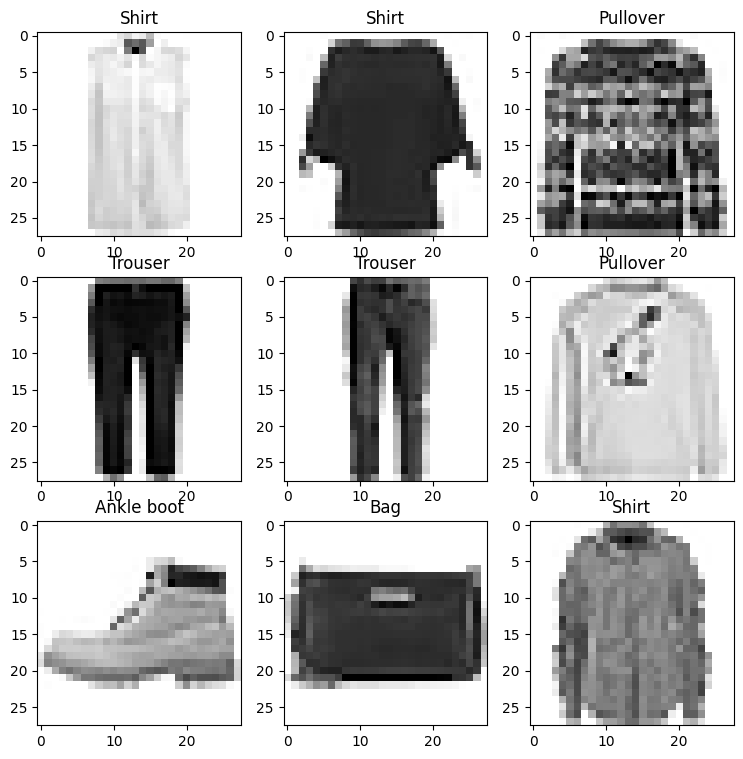

In [31]:
fig = plt.figure(figsize=(9, 9))

rows, cols = 3, 3

for i in range(1, rows * cols + 1):
  rand_idx = torch.randint(0, len(training_data), (1,)).item()
  fig.add_subplot(rows, cols, i)
  feat, label = training_data[rand_idx]
  plt.title(training_data.classes[label])
  plt.imshow(feat.squeeze(), cmap=plt.cm.gray_r)

In [32]:
from torch.utils.data import DataLoader
training_dataloader = DataLoader(dataset=training_data, batch_size=32, shuffle=True)
testing_dataloader = DataLoader(dataset=testing_data, batch_size=32, shuffle=False)

In [33]:
len(training_data.classes)

10

In [34]:
class FashionModel(nn.Module):
  def __init__(self, hidden_layers = 10):
    super().__init__()

    self.seq = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=784, out_features=hidden_layers),
        nn.Linear(in_features=hidden_layers, out_features=10)
    )
  def forward(self, x):
    return self.seq(x)

In [35]:
model = FashionModel()

In [36]:
# setpup the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# loss function
loss_fn = torch.nn.CrossEntropyLoss()
# accuracy function
acc_fn = Accuracy(task='multiclass', num_classes=len(training_data.classes))

In [48]:
epochs = 3

for epoch in tqdm(range(epochs)):
    
    avg_train_loss = 0
    avg_train_acc = 0

    avg_test_loss = 0
    avg_test_acc = 0

    for X_train, y_train in training_dataloader:
        # put the model in the training mode
        model.train()

        # do the forward pass
        logits = model(X_train)
        preds = torch.softmax(logits, dim=1).argmax(dim=1)
        # calculate the loss
        loss = loss_fn(logits, y_train)
        avg_test_loss += loss

        # calculate the accuracy
        acc = acc_fn(preds, y_train)
        avg_test_acc += acc

        # zero the optimizer gradients
        optimizer.zero_grad()
        # backpropagtion
        loss.backward()

    for X_test, y_test in testing_dataloader:
        # do the testing phase
        model.eval()

        # activate the inference context
        with torch.inference_mode():
            test_logits = model(X_test)
            test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
            # calculate the test loss
            test_loss = loss_fn(test_logits, y_test)
            avg_test_loss += test_loss
            # calculate the test acc
            test_acc = acc_fn(test_preds, y_test)
            avg_test_acc += test_acc



100%|██████████| 3/3 [01:12<00:00, 24.07s/it]
